In [1]:
from federated_learning.utils import SHAPUtil, experiment_util
from federated_learning import ClientPlane, Configuration, ObserverConfiguration
from federated_learning.server import Server
from datetime import datetime
import random

In [2]:
import shap
import numpy as np
class Visualizer():
    
    def __init__(self, shap_util):
        self.shap_util = shap_util
        
    def plot_shap_images(shap_indices, shap_images):
        """
        Plot sample images and their target labels
        """
        import matplotlib.pyplot as plt
        fig = plt.figure()
        for i, idx in enumerate(shap_indices):
            plt.subplot(3,4,i+1)
            plt.tight_layout()
            plt.imshow(shap_images[idx][0], cmap='gray', interpolation='none')
            plt.title("Ground Truth: {}".format(self.targets[idx]))
            plt.xticks([])
            plt.yticks([])
        plt.show()
        
    def plot_shap_values(self, shap_values, file=None):
        """
        Plot SHAP values and image
        :param shap_values: name of file
        :type shap_values: Tensor
        :param file: name of file
        :type file: os.path
        """
        import matplotlib.pyplot as plt
        shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
        test_numpy = np.swapaxes(np.swapaxes(self.shap_util.shap_images.numpy(), 1, -1), 1, 2)
        if file:
            shap.image_plot(shap_numpy*1000, -test_numpy, show=False)
            if not os.path.exists(os.path.dirname(file)):
                os.makedirs(os.path.dirname(file))
            plt.savefig(file)
        else: 
            shap.image_plot(shap_numpy, -test_numpy)
            
    def compare_shap_values(self, shap_values, server_shap, file=None):
        """
        Plot SHAP values and image
        :param shap_values: name of file
        :type shap_values: Tensor
        :param file: name of file
        :type file: os.path
        """
        import matplotlib.pyplot as plt
        for row_idx, row in enumerate(shap_values):
            for img_idx, image in enumerate(row):
                shap_values[row_idx][img_idx]= np.subtract(image, server_shap[row_idx][img_idx])
        shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
        test_numpy = np.swapaxes(np.swapaxes(self.shap_util.shap_images.numpy(), 1, -1), 1, 2)
        if file:
            shap.image_plot(shap_numpy, -test_numpy, show=False)
            if not os.path.exists(os.path.dirname(file)):
                os.makedirs(os.path.dirname(file))
            plt.savefig(file)
        else: 
            shap.image_plot(shap_numpy, -test_numpy)

In [ ]:
class ExperimentalSummary():

In [ ]:
class SHAPStats():
    

## Configurations

In [3]:
config = Configuration()
config.FROM_LABEL = 5
config.TO_LABEL = 4
config.POISONED_CLIENTS = 10
data = config.DATASET(config)
shap_util = SHAPUtil(data.test_dataloader)
observer_config = ObserverConfiguration()
visualizer = Visualizer(shap_util)

MNIST training data loaded.
MNIST test data loaded.


## Experimental Setup

In [4]:
server = Server(config, observer_config,data.train_dataloader, data.test_dataloader, shap_util)
client_plane = ClientPlane(config, observer_config, data, shap_util)
client_plane.poison_clients()
clean_idx = experiment_util.select_random_clean(client_plane, config, 10)
poisoned_idx = experiment_util.select_poisoned(client_plane, 10)
print(clean_idx, poisoned_idx)

Create 200 clients with dataset of size 300
Poison 10/200 clients
Flip 100.0% of the 5 labels to 4
[ 16  38  73 188 145  36 125 110 104  76]
[142, 46, 96, 25, 41, 75, 166, 59, 58, 107] [ 16  38  73 188 145  36 125 110 104  76]


## Experiment


Test set: Average loss: 0.0005, Accuracy: 9114/10000 (91%)

Server 1


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


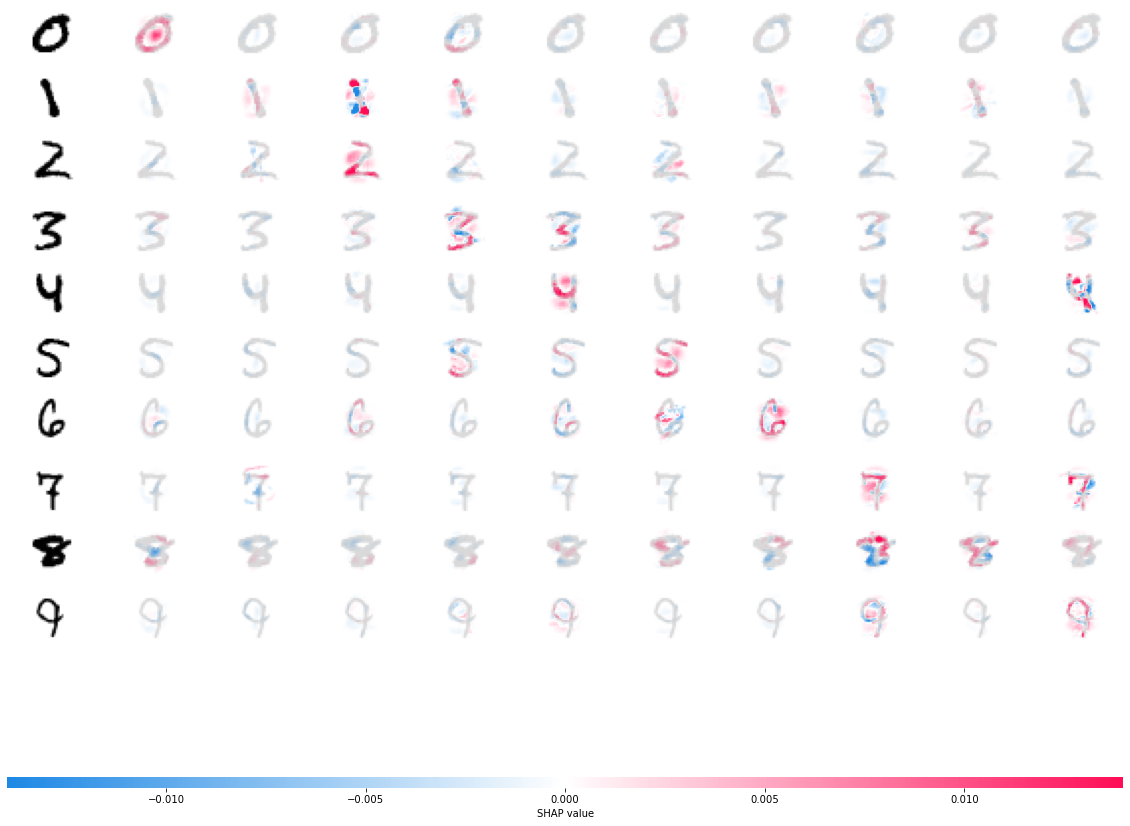

Client Clean 1


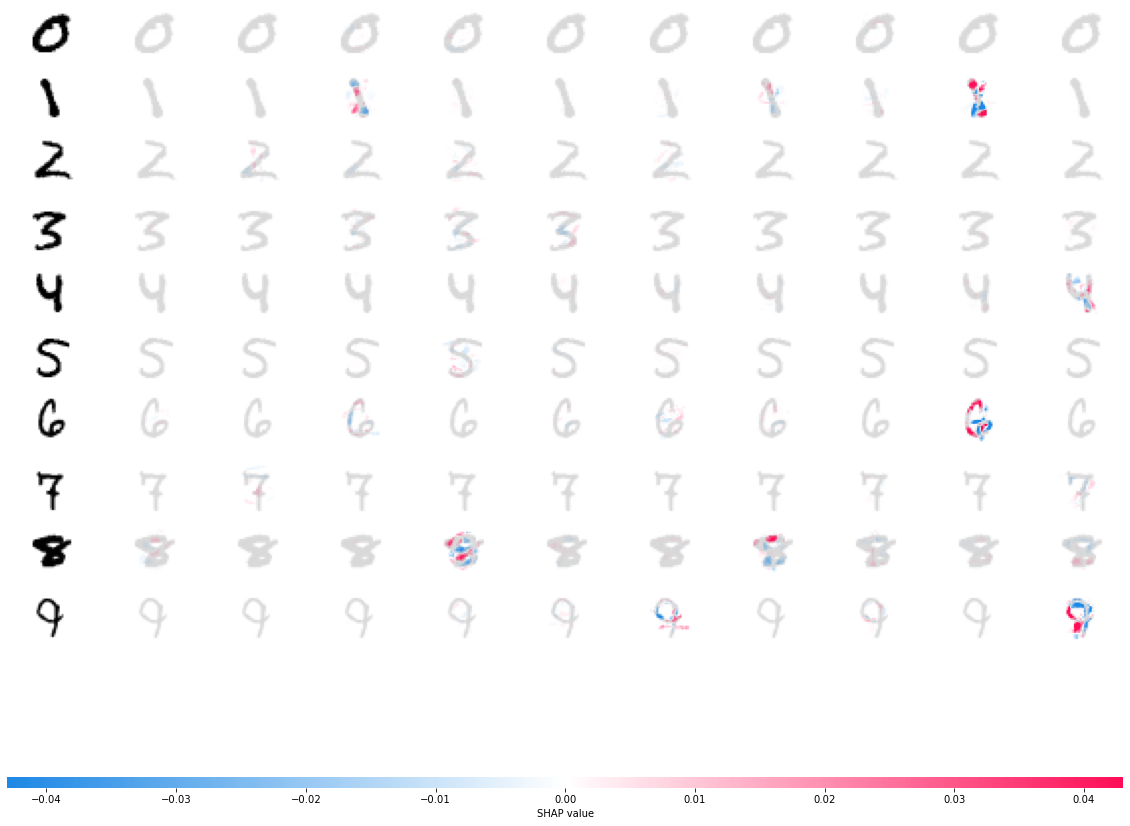

Client Clean 1


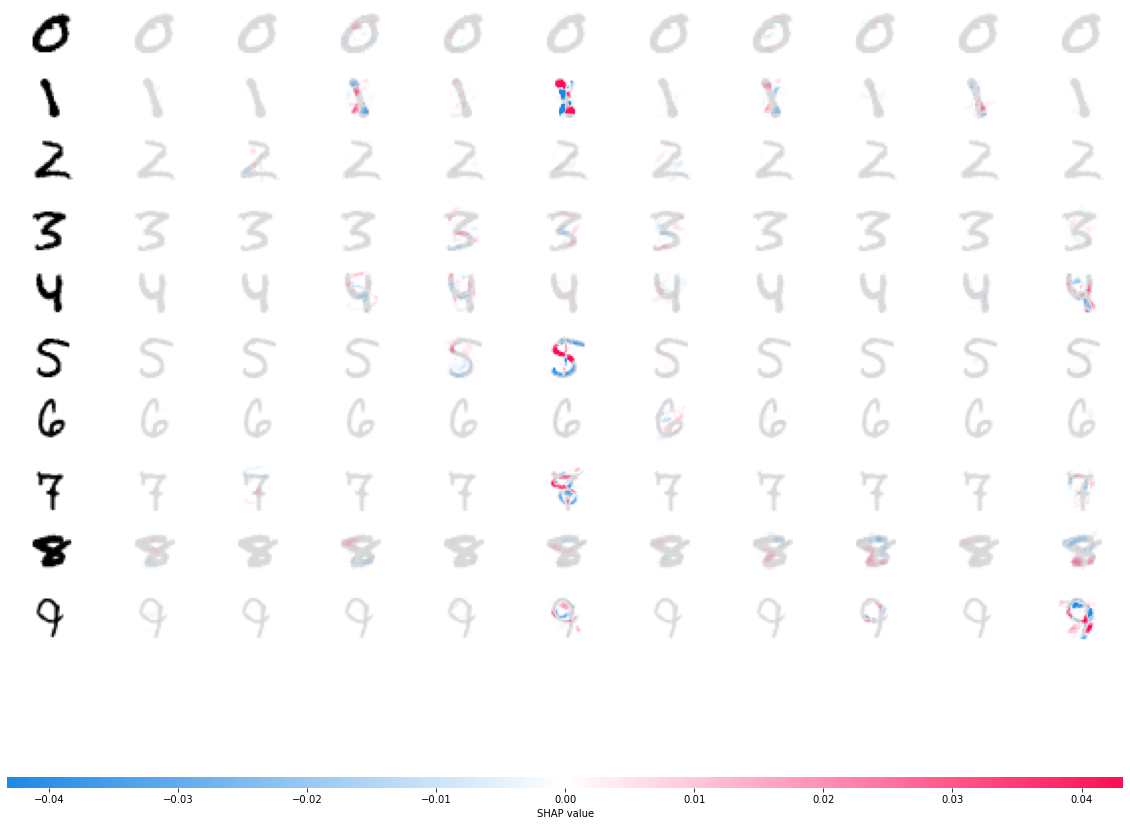

Client Clean 1


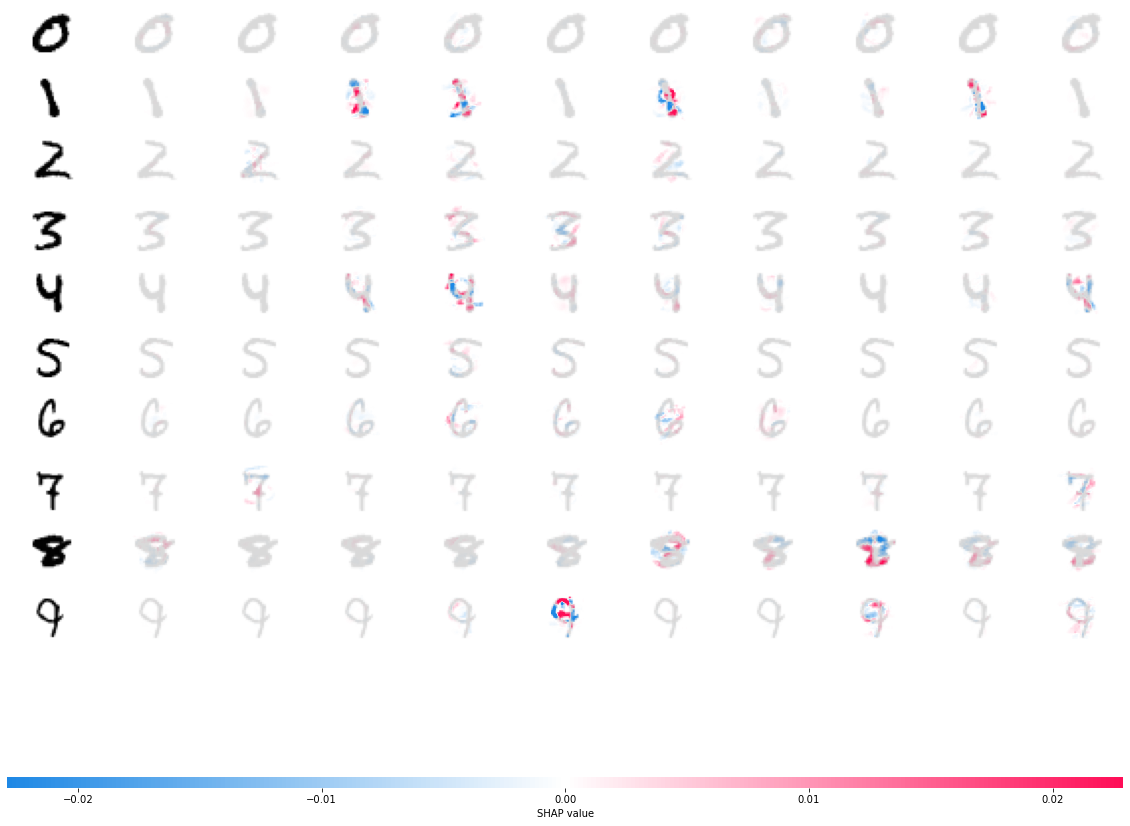

Client Clean 1


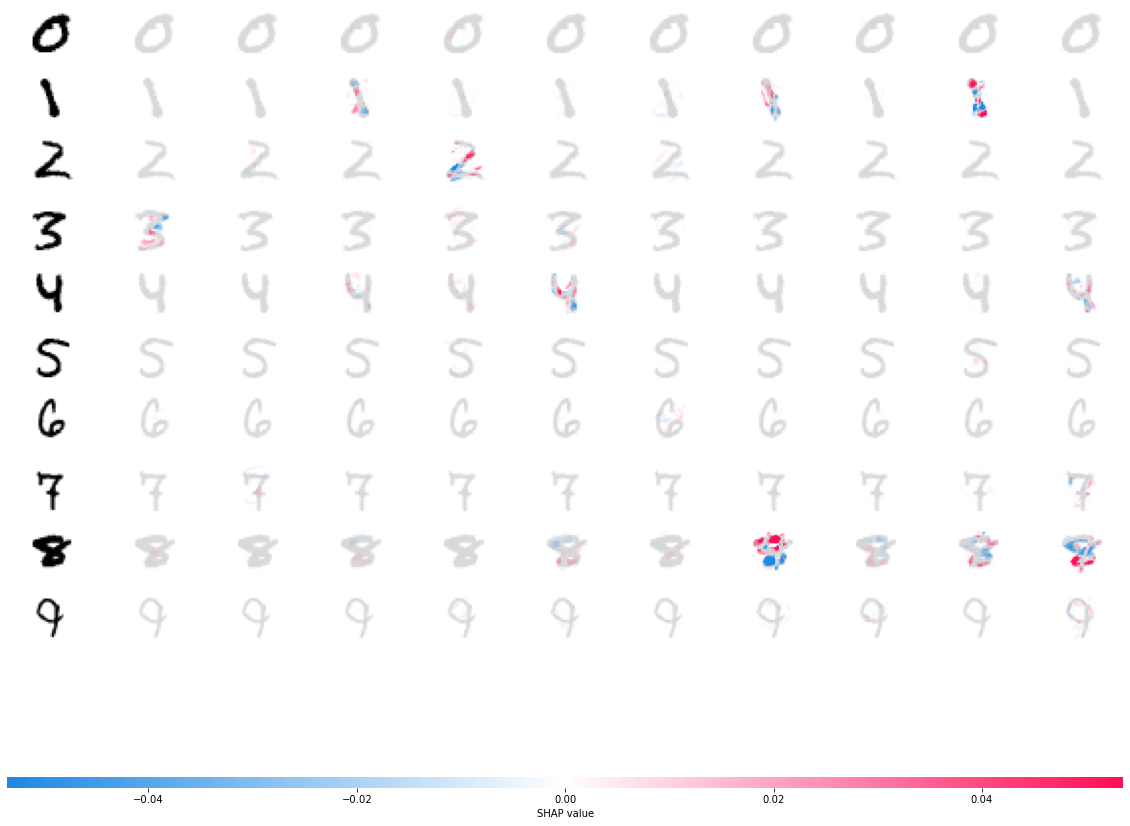

Client Clean 1


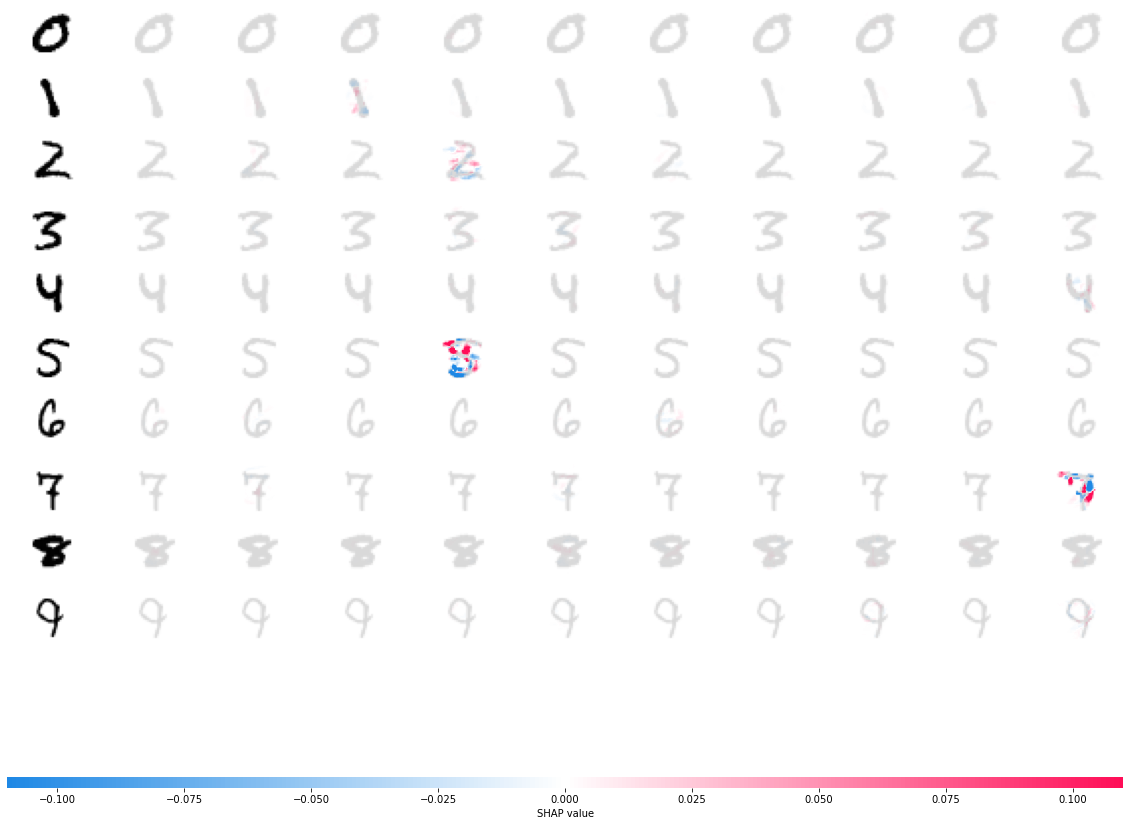

Client Clean 1


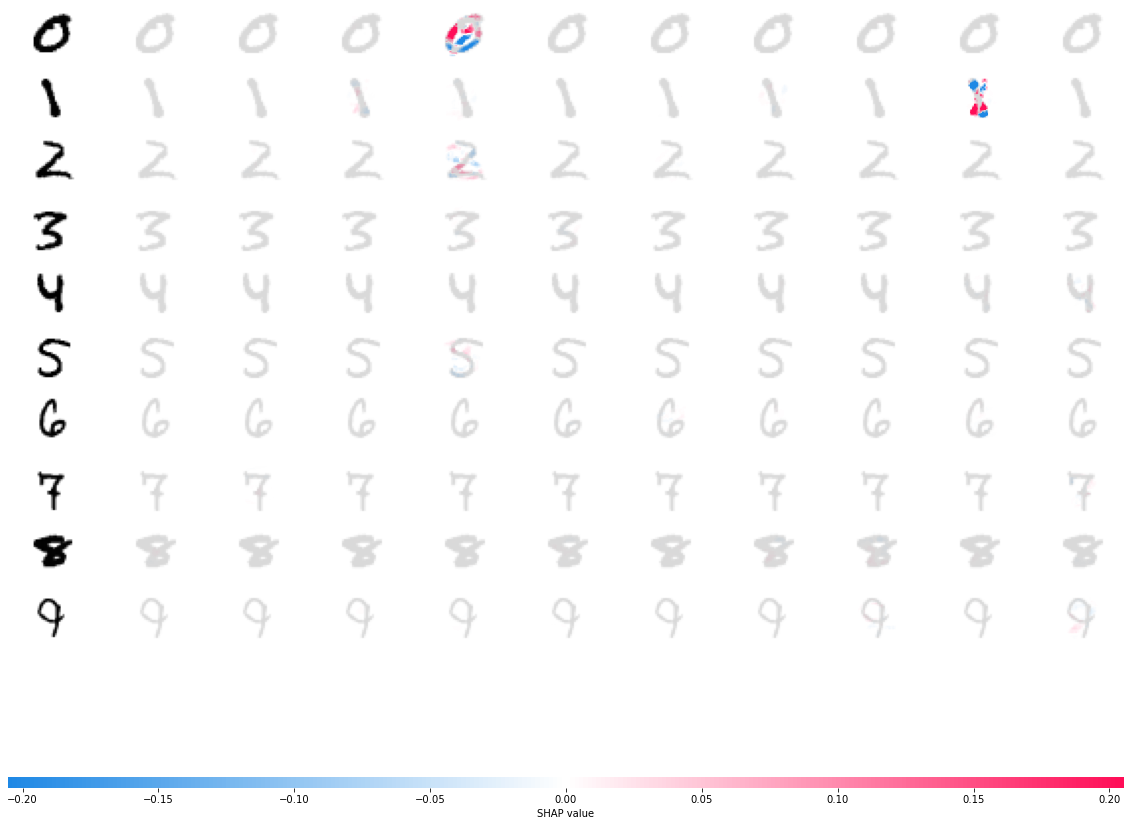

Client Clean 1


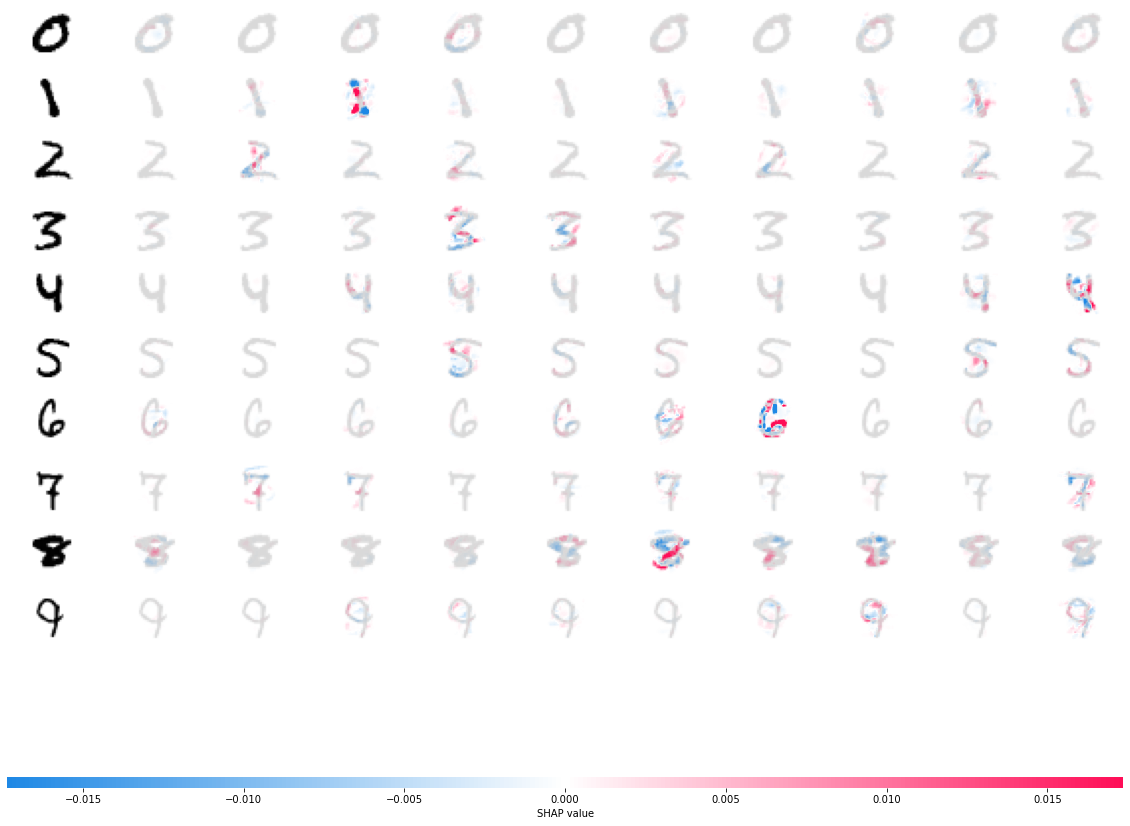

Client Clean 1


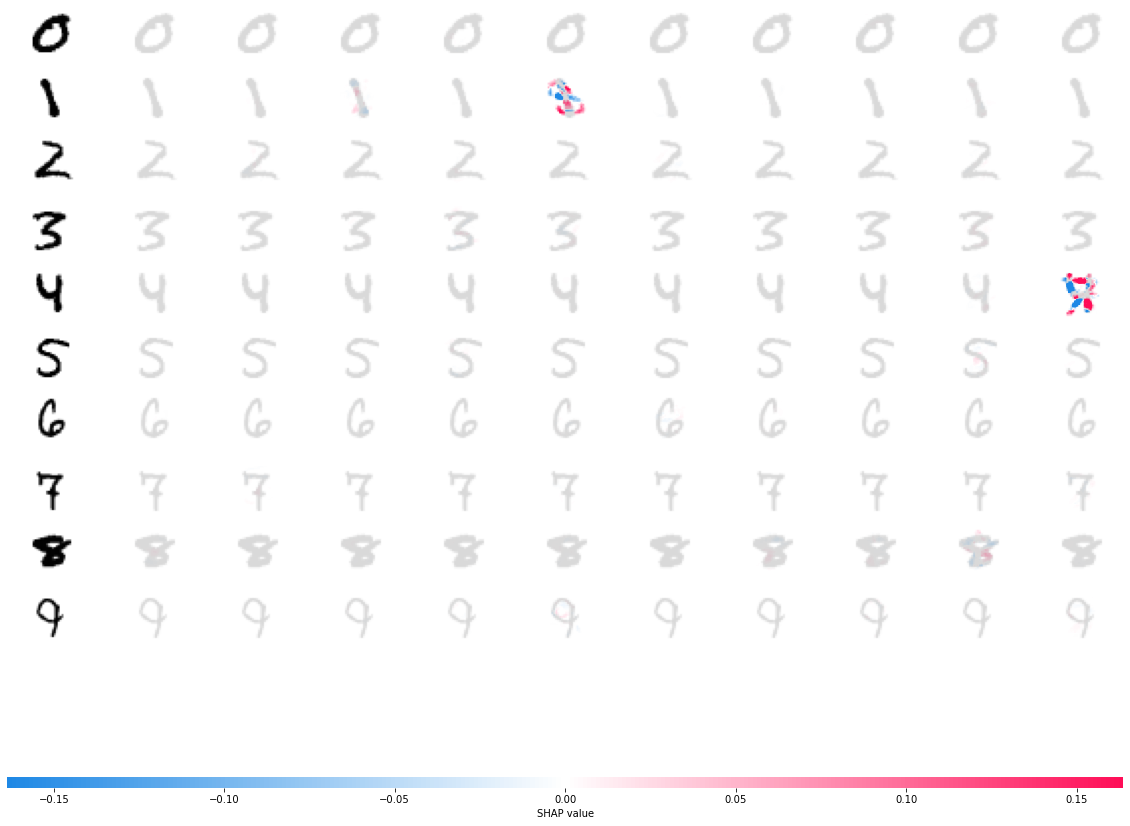

Client Clean 1


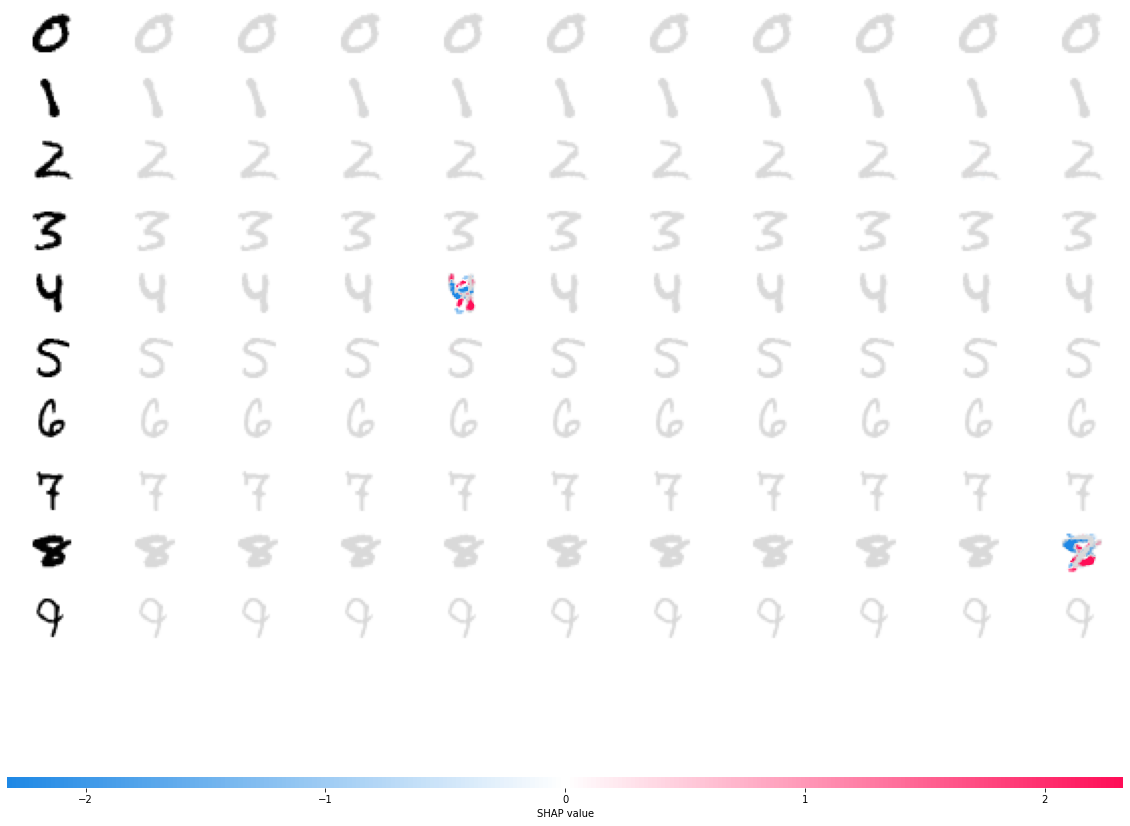

Client Clean 1


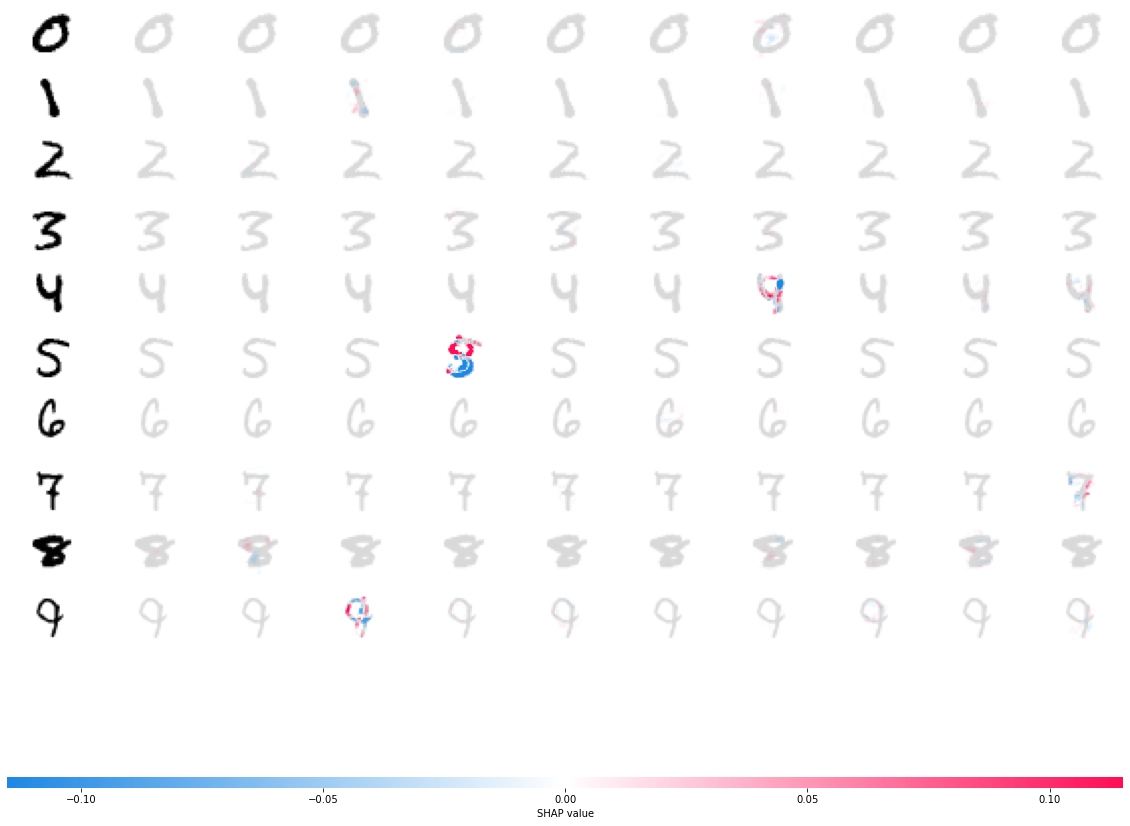

Client Poisoned 1


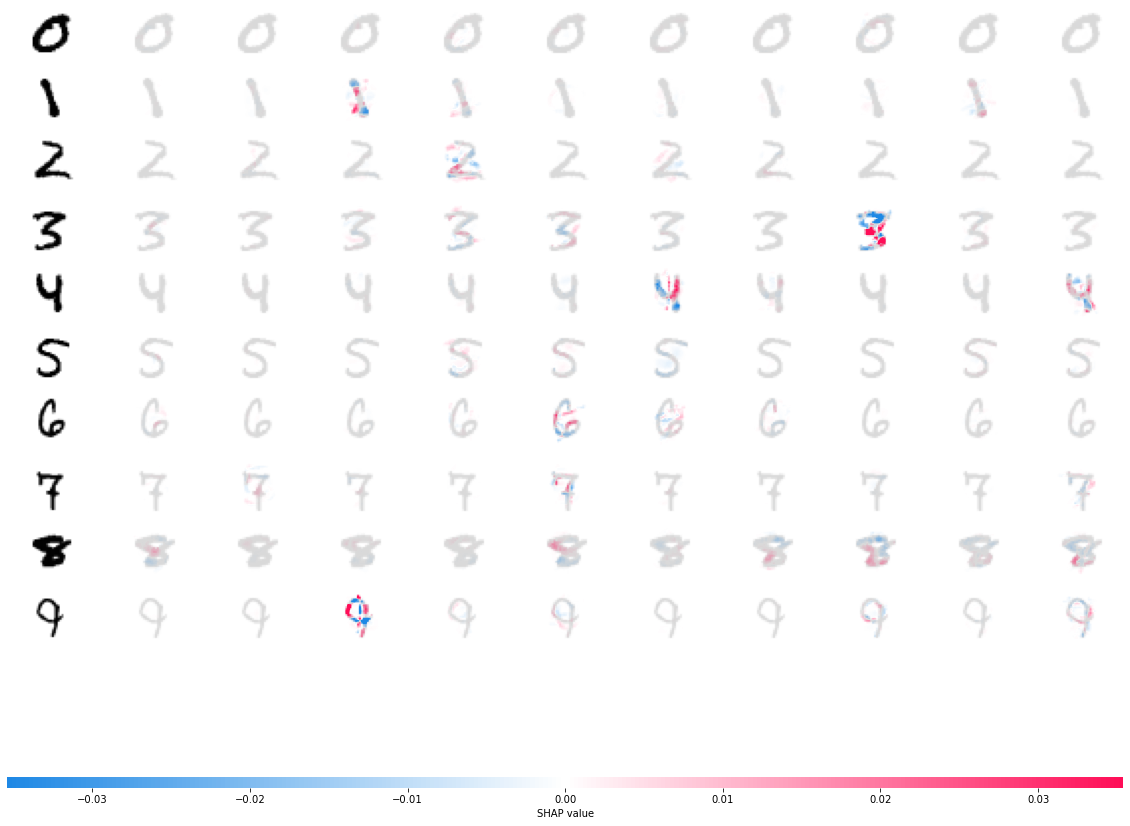

Client Poisoned 1


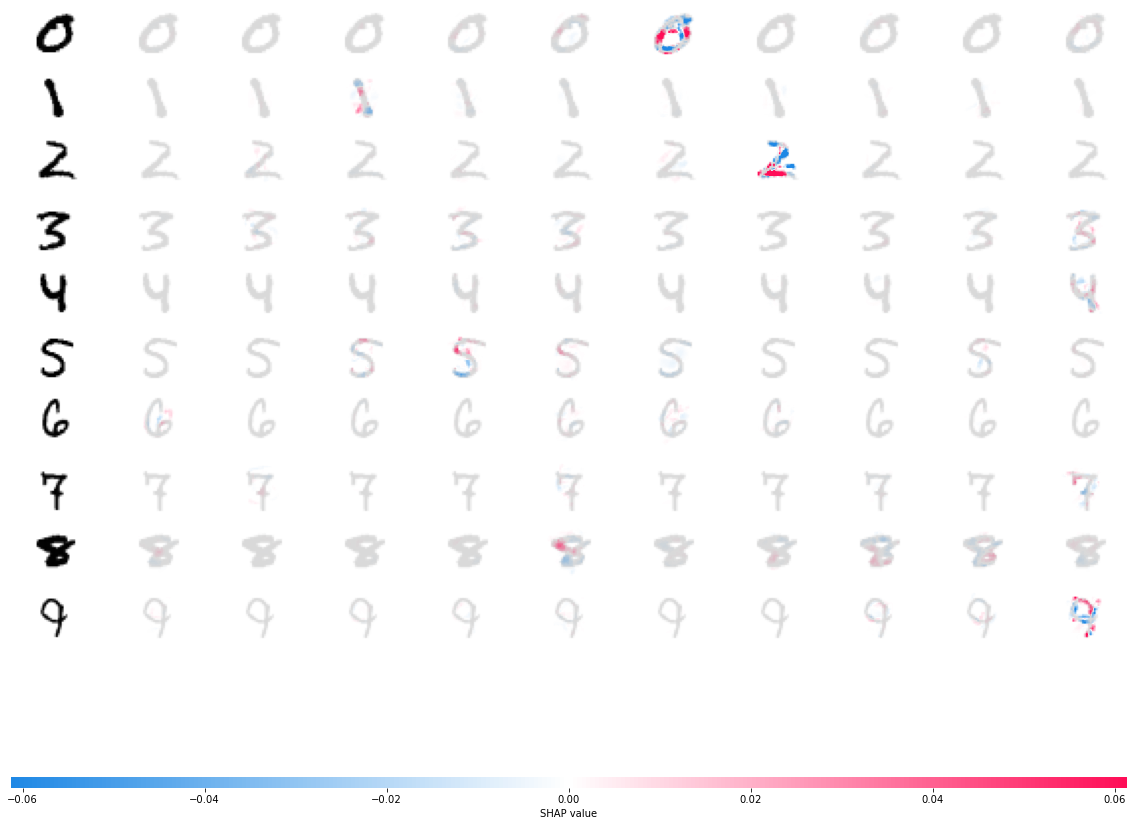

Client Poisoned 1


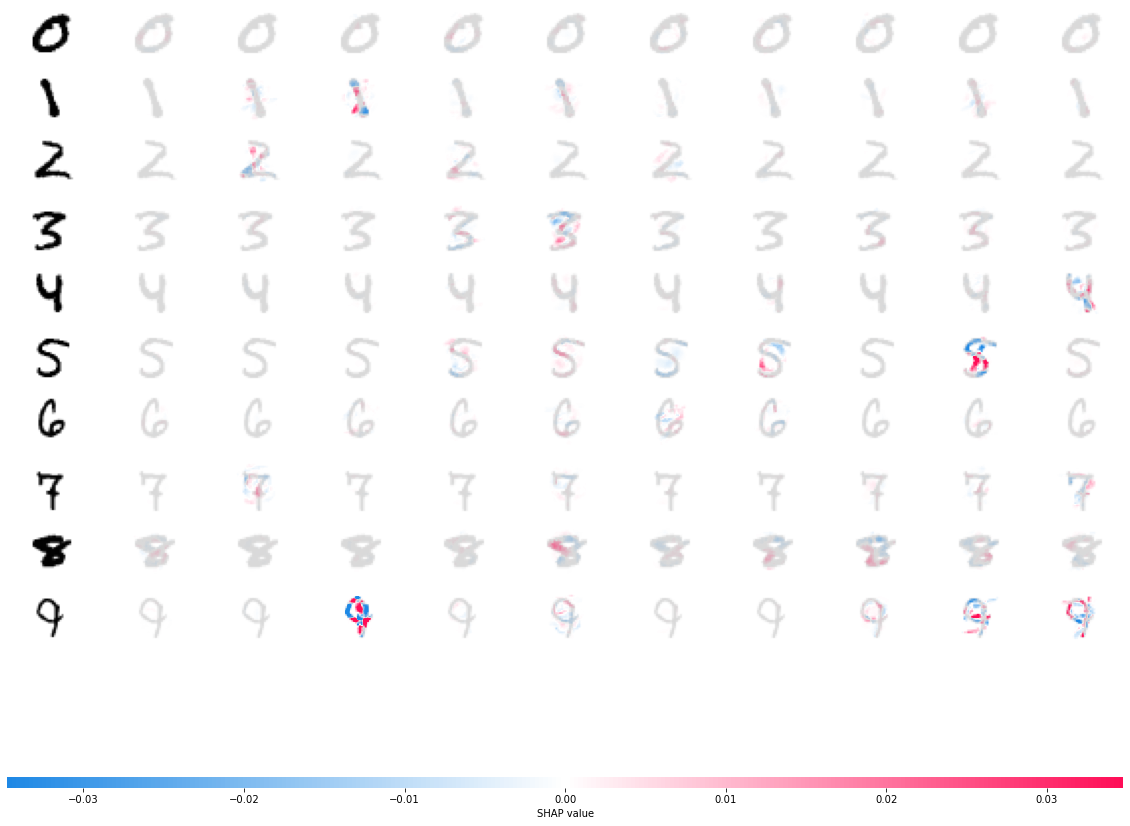

Client Poisoned 1


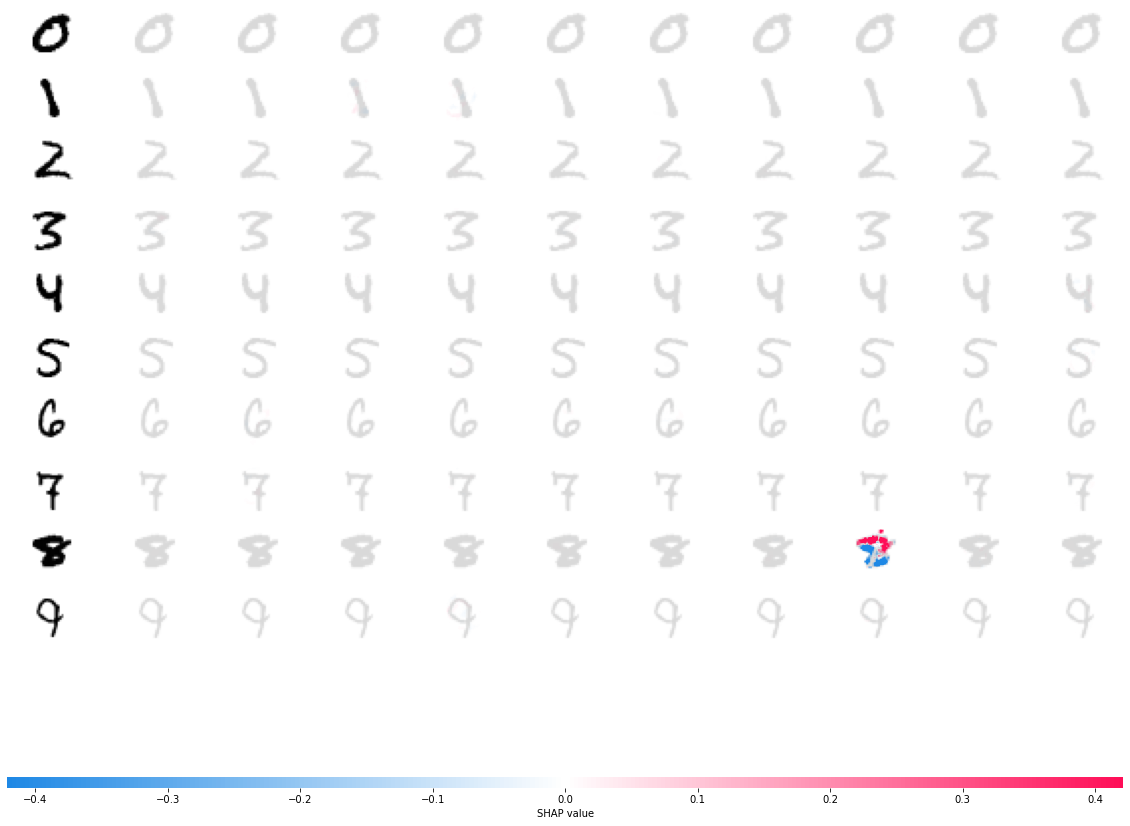

Client Poisoned 1


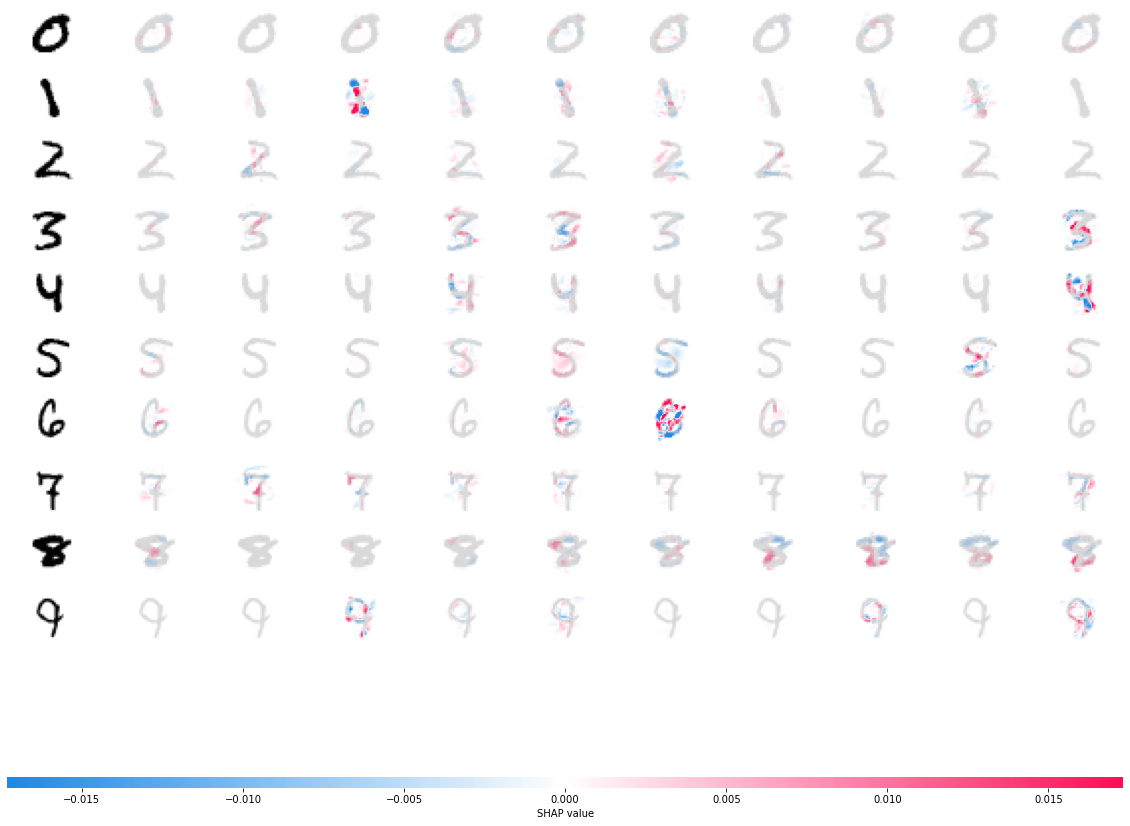

Client Poisoned 1


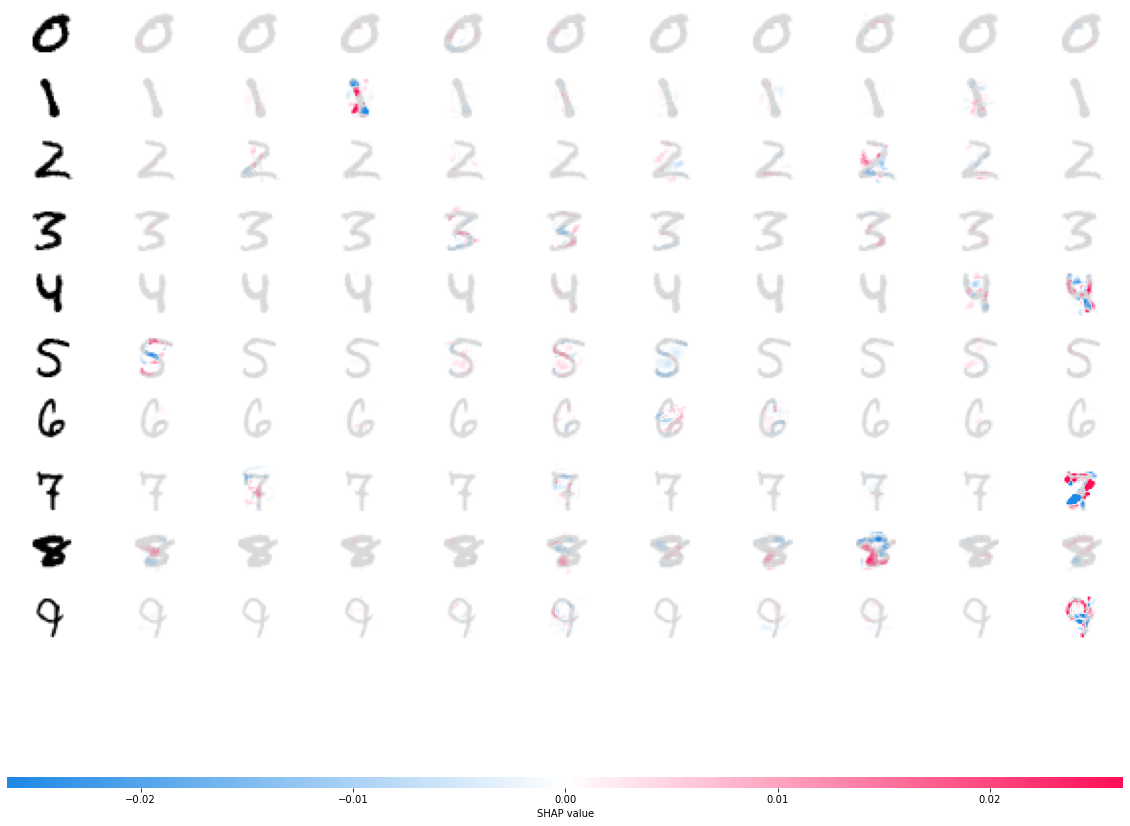

Client Poisoned 1


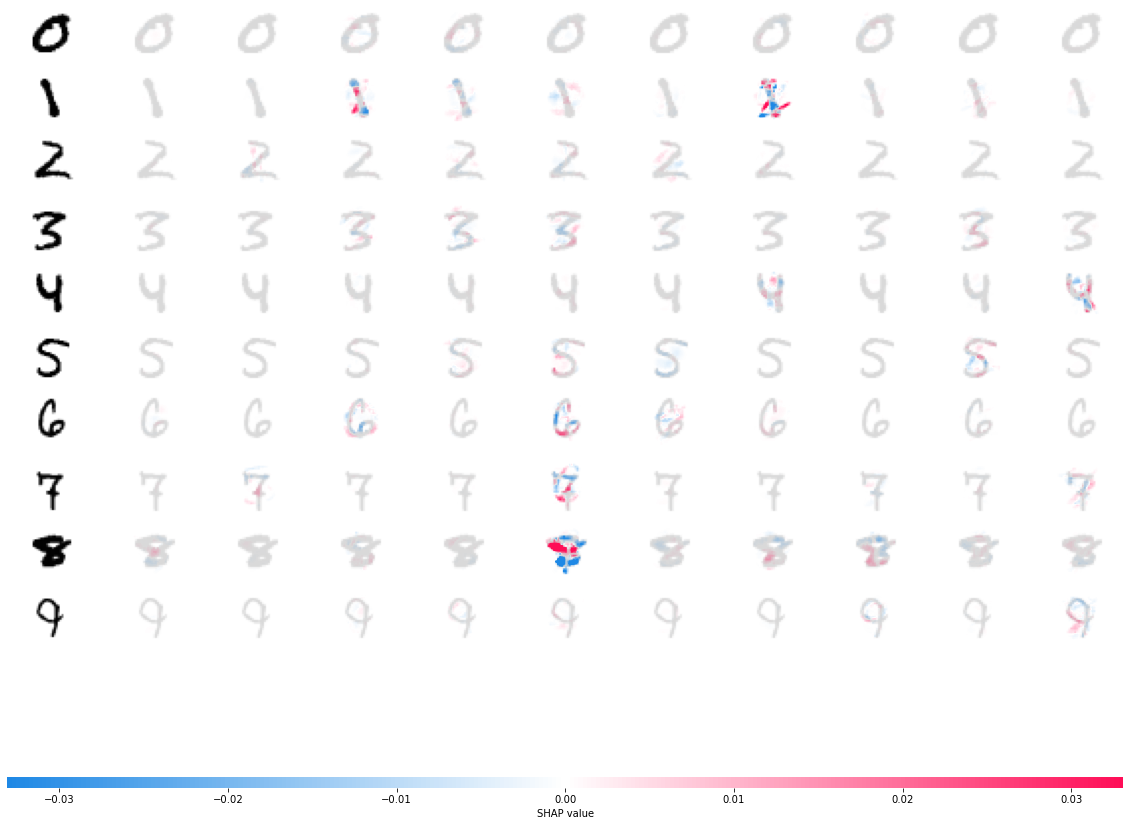

Client Poisoned 1


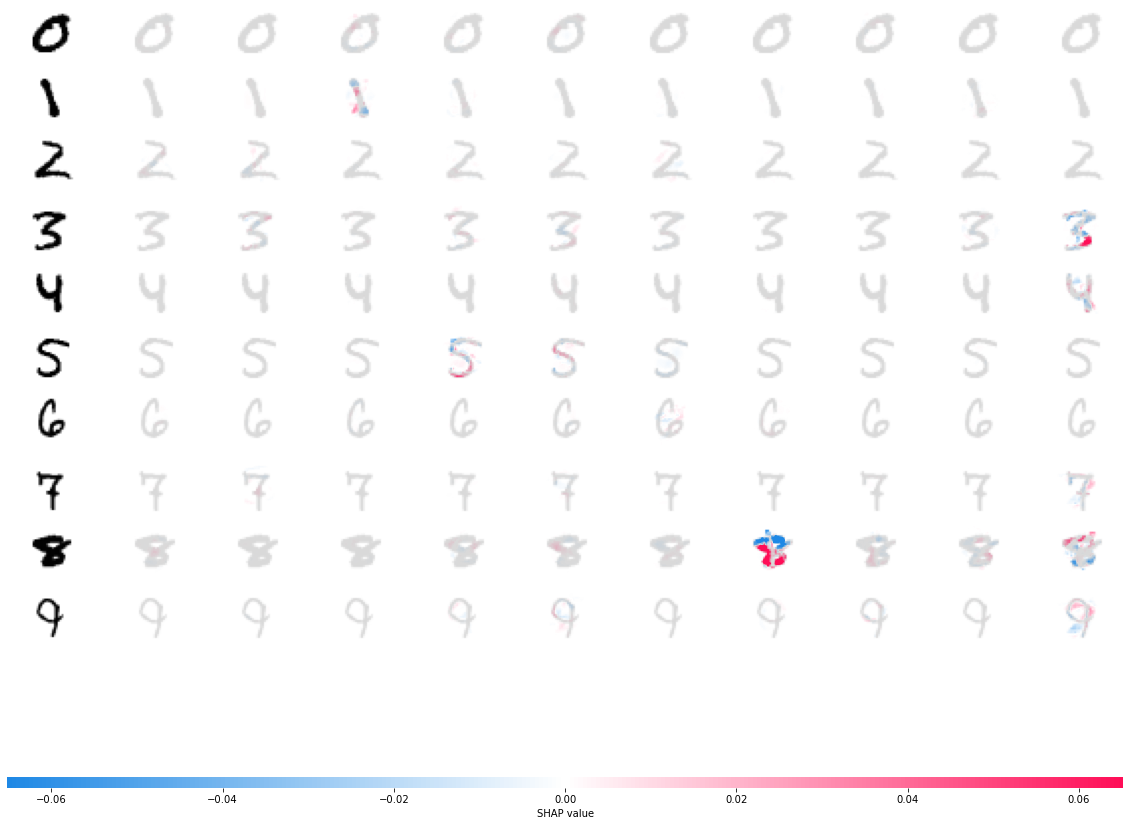

Client Poisoned 1


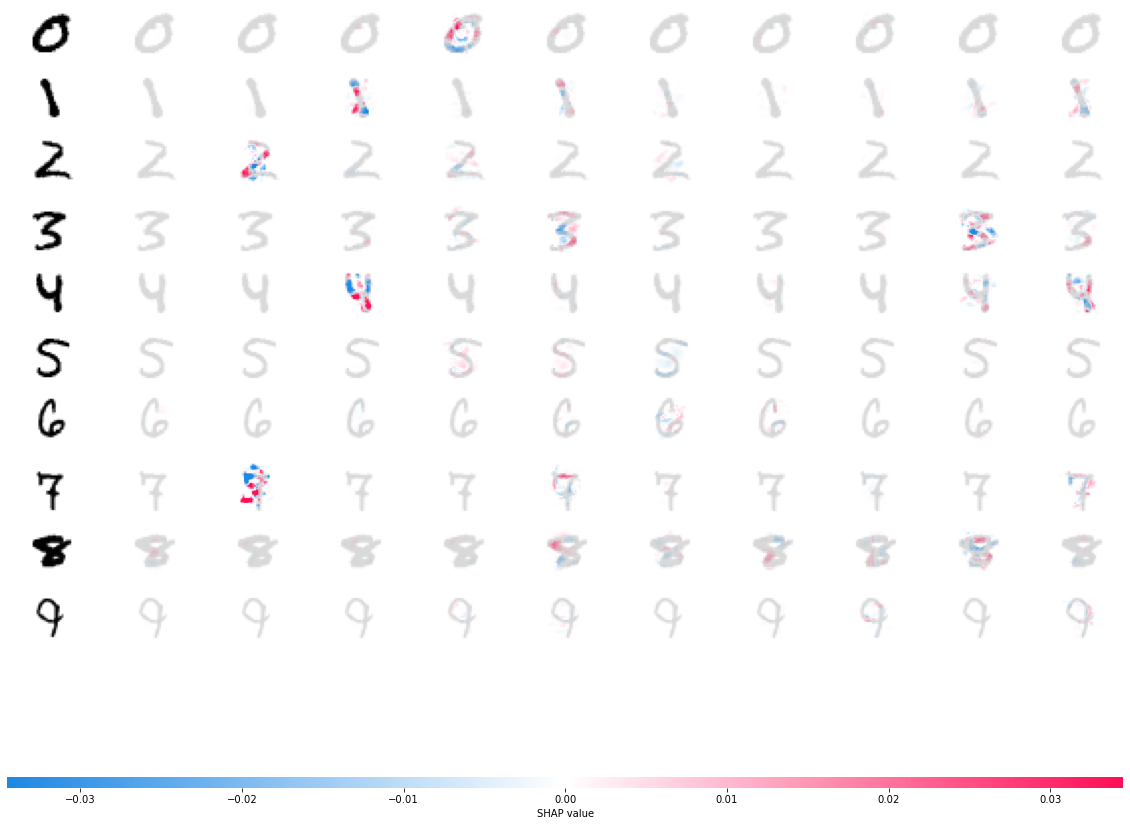

Client Poisoned 1


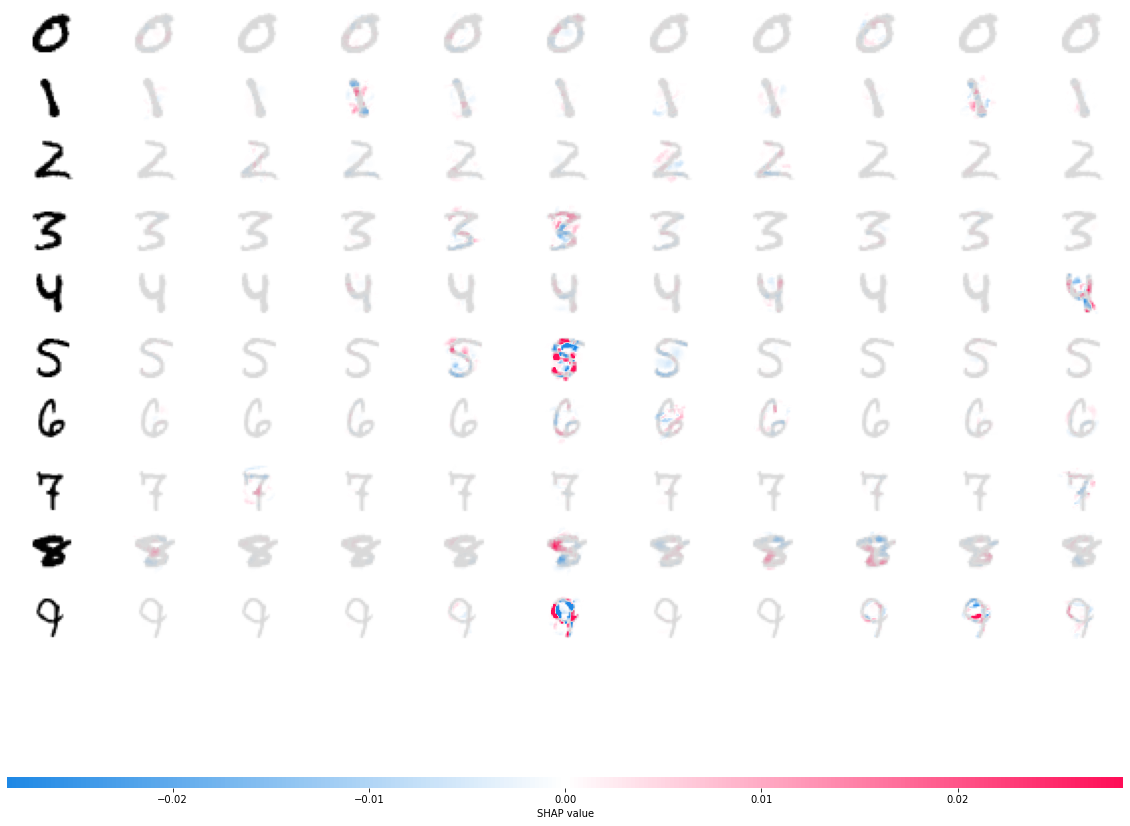

Round 1 finished


In [5]:
for i in range(20):
    experiment_util.run_round(client_plane, server, i+1)
for i in range(1):
    experiment_util.run_round(client_plane, server, i+1)
    server.test()
    print("Server {}".format(i+1))
    server_shap = server.get_shap_values()
    visualizer.plot_shap_values(server_shap)
    client_plane.update_clients(server.get_nn_parameters())
    for j in range(10):
        print("Client Clean {}".format(i+1))
        client_plane.clients[clean_idx[j]].train(i+1)
        client_shap = client_plane.clients[clean_idx[j]].get_shap_values()
        visualizer.compare_shap_values(client_shap, server_shap)
    for j in range(10):
        print("Client Poisoned {}".format(i+1))
        client_plane.clients[poisoned_idx[j]].train(i+1)
        client_shap = client_plane.clients[poisoned_idx[j]].get_shap_values()
        visualizer.compare_shap_values(client_shap, server_shap)
    print("Round {} finished".format(i+1))

In [ ]:
for i in range(10):
    experiment_util.run_round(i+1, client_plane, server)

In [ ]:
server_shap = server.get_shap_values()
client_plane.update_clients(server.get_nn_parameters())
for j in range(1):
    print("Client Clean {}".format(10))
    client_plane.clients[clean_idx[j]].train(10)
    client_shap = client_plane.clients[clean_idx[j]].get_shap_values()
    visualizer.compare_shap_values(client_shap, server_shap)